## Postprocessing head results from MODFLOW

In [6]:
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

from flopy.utils.postprocessing import (
    get_transmissivities,
    get_water_table,
    get_gradients,
)
import flopy.utils.binaryfile as bf

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


In [7]:
mfnam = "EXAMPLE.nam"
model_ws = "../../examples/data/mp6/"
heads_file = "EXAMPLE.HED"

# temporary directory
temp_dir = TemporaryDirectory()
workspace = temp_dir.name

### Load example model and head results

In [8]:
m = flopy.modflow.Modflow.load(mfnam, model_ws=model_ws)

In [9]:
hdsobj = bf.HeadFile(model_ws + heads_file)
hds = hdsobj.get_data(kstpkper=(0, 2))
hds.shape

(5, 25, 25)

### Plot heads in each layer; export the heads and head contours for viewing in a GIS
for more information about GIS export, type `help(export_array)`, for example

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object

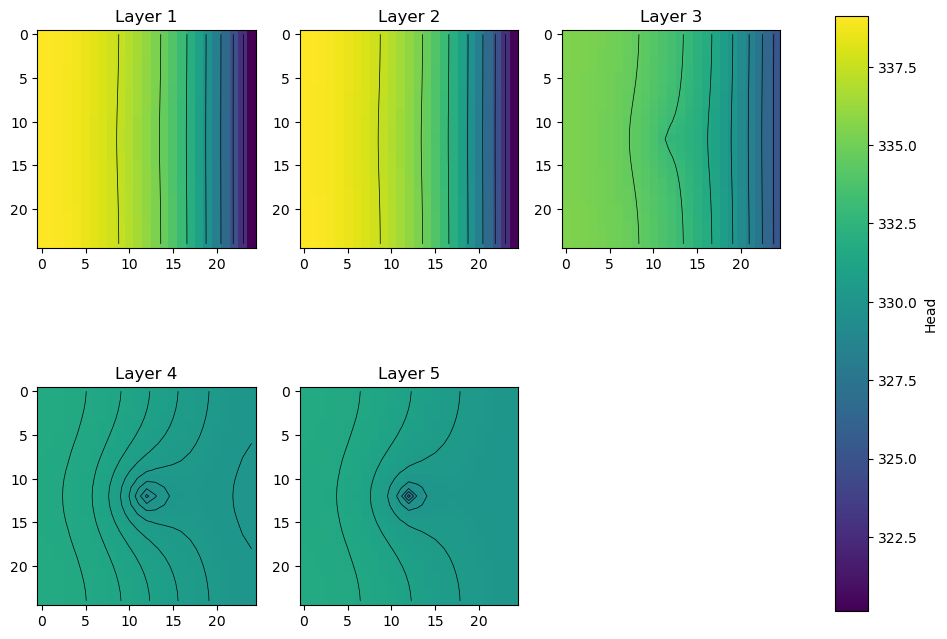

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(11, 8.5))
axes = axes.flat
grid = m.modelgrid
for i, hdslayer in enumerate(hds):
    im = axes[i].imshow(hdslayer, vmin=hds.min(), vmax=hds.max())
    axes[i].set_title("Layer {}".format(i + 1))
    ctr = axes[i].contour(hdslayer, colors="k", linewidths=0.5)

    # export head rasters
    # (GeoTiff export requires the rasterio package; for ascii grids, just change the extension to *.asc)
    flopy.export.utils.export_array(
        grid, os.path.join(workspace, "heads{}.tif".format(i + 1)), hdslayer
    )

    # export head contours to a shapefile
    flopy.export.utils.export_array_contours(
        grid, os.path.join(workspace, "heads{}.shp".format(i + 1)), hdslayer
    )

fig.delaxes(axes[-1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Head");

### Compare rotated arc-ascii and GeoTiff output

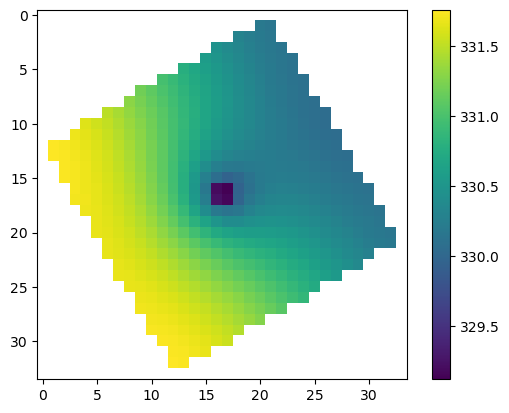

In [11]:
grid.set_coord_info(angrot=30.0)
nodata = 0.0
flopy.export.utils.export_array(
    grid, os.path.join(workspace, "heads5_rot.asc"), hdslayer, nodata=nodata
)
flopy.export.utils.export_array(
    grid, os.path.join(workspace, "heads5_rot.tif"), hdslayer, nodata=nodata
)

results = np.loadtxt(
    os.path.join(workspace, "heads5_rot.asc".format(i + 1)), skiprows=6
)
results[results == nodata] = np.nan
plt.imshow(results)
plt.colorbar();

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 25, 'height': 25, 'count': 1, 'crs': None, 'transform': Affine(346.4101615137755, 199.99999999999997, -4999.999999999999,
       199.99999999999997, -346.4101615137755, 8660.254037844386)}


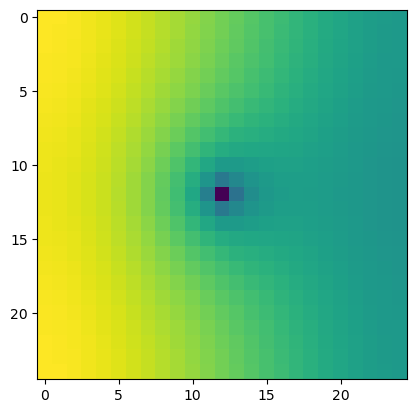

In [12]:
try:
    import rasterio
except:
    rasterio = None
    print("install rasterio to create GeoTiff output")
if rasterio is not None:
    with rasterio.open(os.path.join(workspace, "heads5_rot.tif")) as src:
        print(src.meta)
        plt.imshow(src.read(1))

### Get the vertical head gradients between layers

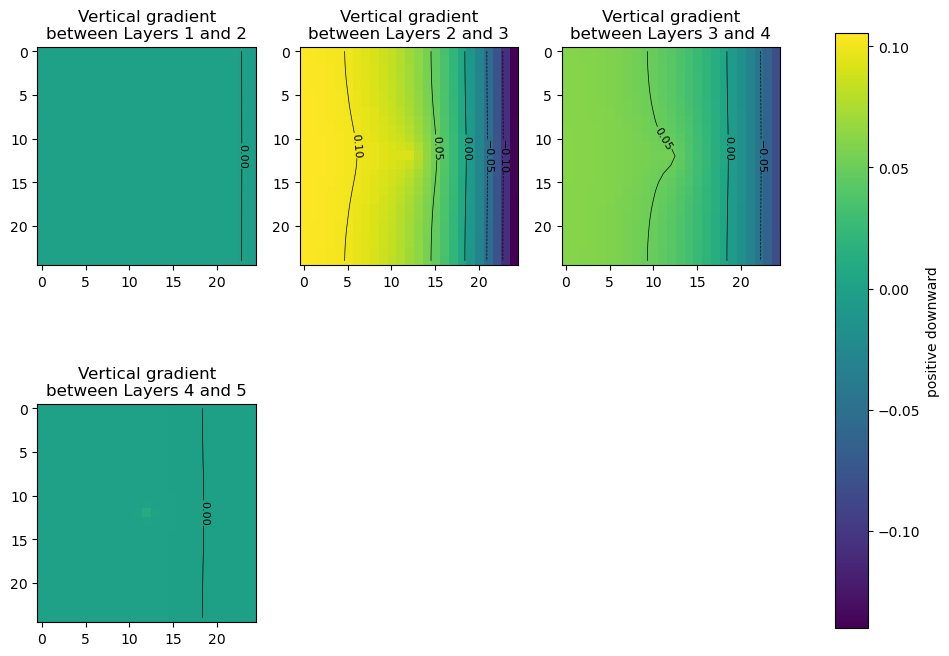

In [13]:
grad = get_gradients(hds, m, nodata=-999)

fig, axes = plt.subplots(2, 3, figsize=(11, 8.5))
axes = axes.flat

for i, vertical_gradient in enumerate(grad):
    im = axes[i].imshow(vertical_gradient, vmin=grad.min(), vmax=grad.max())
    axes[i].set_title(
        "Vertical gradient\nbetween Layers {} and {}".format(i + 1, i + 2)
    )
    ctr = axes[i].contour(
        vertical_gradient,
        levels=[-0.1, -0.05, 0.0, 0.05, 0.1],
        colors="k",
        linewidths=0.5,
    )
    plt.clabel(ctr, fontsize=8, inline=1)

fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label="positive downward");

### Get the saturated thickness of a layer
`m.modelgrid.saturated_thickness()` returns an nlay, nrow, ncol array of saturated thicknesses.

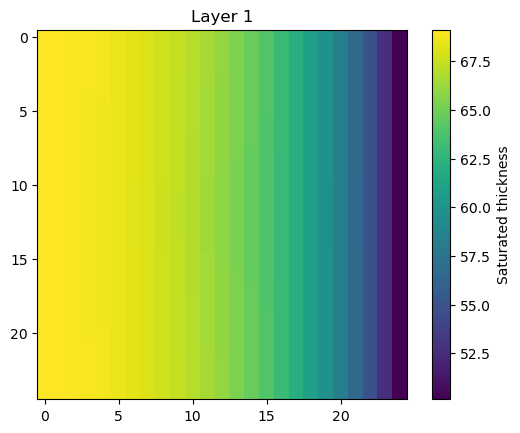

In [14]:
st = m.modelgrid.saturated_thickness(hds, mask=-9999.0)

plt.imshow(st[0])
plt.colorbar(label="Saturated thickness")
plt.title("Layer 1");

### Get the water table
`get_water_table()` returns an nrow, ncol array of the water table elevation.  
This method can be useful when HDRY is turned on and the water table is in multiple layers.

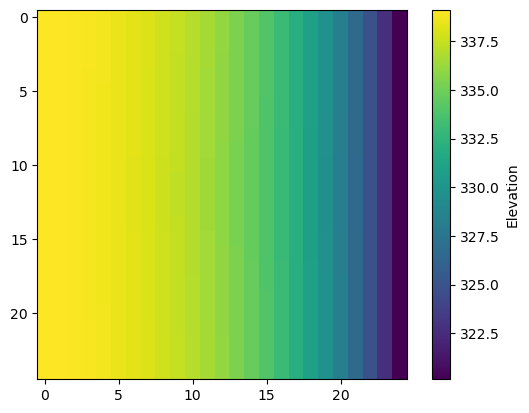

In [15]:
wt = get_water_table(heads=hds, hdry=-9999)

plt.imshow(wt)
plt.colorbar(label="Elevation");

### Get layer transmissivities at arbitrary locations, accounting for the position of the water table
* for this method, the heads input is an nlay x nobs array of head results, which could be constructed using the Hydmod package with an observation in each layer at each observation location, for example . 
* x, y values in real-world coordinates can be used in lieu of row, column, provided a correct coordinate information is supplied to the flopy model object's grid. 
* open interval tops and bottoms can be supplied at each location for computing transmissivity-weighted average heads 
* this method can also be used for apportioning boundary fluxes for an inset from a 2-D regional model  
* see `**flopy3_get_transmissivities_example.ipynb**` for more details on how this method works

In [16]:
r = [20, 5]
c = [5, 20]
headresults = hds[:, r, c]
get_transmissivities(headresults, m, r=r, c=c)

array([[3.42867432e+03, 2.91529083e+03],
       [2.50000000e+03, 2.50000000e+03],
       [1.99999996e-01, 1.99999996e-01],
       [2.00000000e+04, 2.00000000e+04],
       [2.00000000e+04, 2.00000000e+04]])

In [17]:
r = [20, 5]
c = [5, 20]
sctop = [340, 320]  # top of open interval at each location
scbot = [210, 150]  # top of bottom interval at each location
headresults = hds[:, r, c]
tr = get_transmissivities(headresults, m, r=r, c=c, sctop=sctop, scbot=scbot)
tr

array([[3.42867432e+03, 2.50000000e+03],
       [2.50000000e+03, 2.50000000e+03],
       [9.99999978e-02, 1.99999996e-01],
       [0.00000000e+00, 1.00000000e+04],
       [0.00000000e+00, 0.00000000e+00]])

#### convert to transmissivity fractions

In [18]:
trfrac = tr / tr.sum(axis=0)
trfrac

array([[5.78310817e-01, 1.66664444e-01],
       [4.21672316e-01, 1.66664444e-01],
       [1.68668923e-05, 1.33331553e-05],
       [0.00000000e+00, 6.66657778e-01],
       [0.00000000e+00, 0.00000000e+00]])

#### Layer 3 contributes almost no transmissivity because of its K-value

In [19]:
m.lpf.hk.array[:, r, c]

array([[5.e+01, 5.e+01],
       [5.e+01, 5.e+01],
       [1.e-02, 1.e-02],
       [2.e+02, 2.e+02],
       [2.e+02, 2.e+02]], dtype=float32)

In [20]:
m.modelgrid.cell_thickness[:, r, c]

array([[130., 130.],
       [ 50.,  50.],
       [ 20.,  20.],
       [100., 100.],
       [100., 100.]])

In [21]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass